In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [40]:
# Load datasets
application_train = pd.read_csv("cleaned_data/application_train_cleaned.csv")
previous_application = pd.read_csv("cleaned_data/previous_application_cleaned.csv")

In [41]:
# Merge datasets
merged_data = application_train.merge(previous_application, on="SK_ID_CURR", how="left")

In [42]:
# Feature Engineering
merged_data["TOTAL_PREV_LOANS"] = merged_data.groupby("SK_ID_CURR")["SK_ID_PREV"].transform("count")
merged_data["COUNT_APPROVED"] = merged_data.groupby("SK_ID_CURR")["NAME_CONTRACT_STATUS"].transform(lambda x: (x == "Approved").sum())
merged_data["COUNT_REFUSED"] = merged_data.groupby("SK_ID_CURR")["NAME_CONTRACT_STATUS"].transform(lambda x: (x == "Refused").sum())
merged_data["HAS_PREV_LOAN"] = merged_data["TOTAL_PREV_LOANS"].apply(lambda x: 1 if x > 0 else 0)
merged_data["CREDIT_TO_INCOME_RATIO"] = merged_data["AMT_CREDIT_x"] / merged_data["AMT_INCOME_TOTAL"]
merged_data["ANNUITY_TO_INCOME_RATIO"] = merged_data["AMT_ANNUITY_x"] / merged_data["AMT_INCOME_TOTAL"]

In [43]:
# Handle missing values
merged_data.fillna(0, inplace=True)

In [44]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 76 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1430155 non-null  int64  
 1   TARGET                        1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_x          1430155 non-null  object 
 3   CODE_GENDER                   1430155 non-null  object 
 4   FLAG_OWN_CAR                  1430155 non-null  object 
 5   FLAG_OWN_REALTY               1430155 non-null  object 
 6   CNT_CHILDREN                  1430155 non-null  int64  
 7   AMT_INCOME_TOTAL              1430155 non-null  float64
 8   AMT_CREDIT_x                  1430155 non-null  float64
 9   AMT_ANNUITY_x                 1430155 non-null  float64
 10  AMT_GOODS_PRICE_x             1430155 non-null  float64
 11  NAME_TYPE_SUITE               1430155 non-null  object 
 12  NAME_INCOME_TYPE            

C:\Users\User\AppData\Local\Temp\ipykernel_20380\2499971567.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=refused_avg.index, y=refused_avg.values, palette=["blue", "red"])


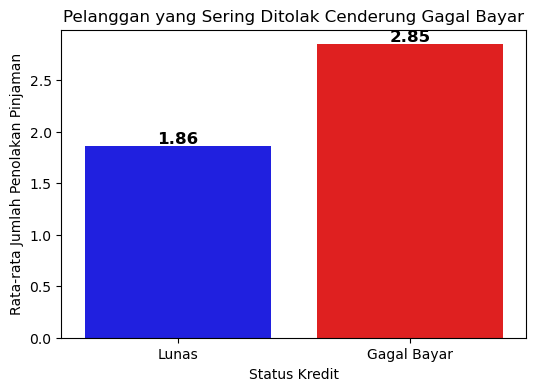

In [138]:
# ===========================
# INSIGHT 1: JUMLAH PENOLAKAN PINJAMAN VS. GAGAL BAYAR
# ===========================

# Hitung rata-rata jumlah penolakan berdasarkan TARGET
refused_avg = merged_data.groupby("TARGET")["COUNT_REFUSED"].mean()

# Buat bar chart
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=refused_avg.index, y=refused_avg.values, palette=["blue", "red"])
plt.xticks([0, 1], ["Lunas", "Gagal Bayar"])
plt.ylabel("Rata-rata Jumlah Penolakan Pinjaman")
plt.xlabel("Status Kredit")
plt.title("Pelanggan yang Sering Ditolak Cenderung Gagal Bayar")

# Tambahkan nilai di atas bar chart
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_20380\2286397409.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ratio_default = merged_data.groupby("RATIO_CATEGORY")["TARGET"].mean() * 100


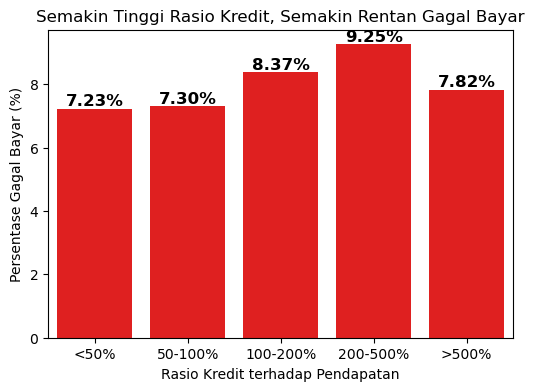

In [140]:
merged_data["RATIO_CATEGORY"] = pd.cut(merged_data["CREDIT_TO_INCOME_RATIO"], bins=[0, 0.5, 1, 2, 5, 10], 
                              labels=["<50%", "50-100%", "100-200%", "200-500%", ">500%"])

# Hitung persentase gagal bayar di setiap kategori rasio
ratio_default = merged_data.groupby("RATIO_CATEGORY")["TARGET"].mean() * 100

# Buat bar chart
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=ratio_default.index, y=ratio_default.values, color="red")
plt.ylabel("Persentase Gagal Bayar (%)")
plt.xlabel("Rasio Kredit terhadap Pendapatan")
plt.title("Semakin Tinggi Rasio Kredit, Semakin Rentan Gagal Bayar")

# Tambahkan nilai di atas bar chart
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_20380\1730620278.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="pastel")


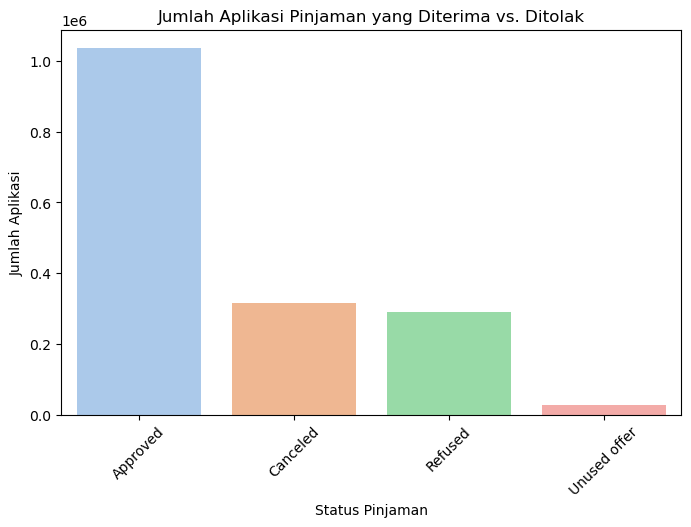

NAME_CONTRACT_STATUS
Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: count, dtype: int64


In [45]:
# Hitung jumlah orang yang diterima dan ditolak pengajuannya
loan_status_counts = previous_application["NAME_CONTRACT_STATUS"].value_counts()

# Visualisasi
plt.figure(figsize=(8, 5))
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, palette="pastel")
plt.title("Jumlah Aplikasi Pinjaman yang Diterima vs. Ditolak")
plt.xlabel("Status Pinjaman")
plt.ylabel("Jumlah Aplikasi")
plt.xticks(rotation=45)
plt.show()

# Print jumlahnya
print(loan_status_counts)


In [46]:
# Fungsi untuk menghapus outlier dengan metode IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Data klien yang DITOLAK
refused_clients = merged_data[merged_data["NAME_CONTRACT_STATUS"] == "Refused"]
refused_clients_clean = remove_outliers(refused_clients, "AMT_CREDIT_x")
refused_clients_sorted = refused_clients_clean.sort_values(by="AMT_CREDIT_x", ascending=False)

# Data klien yang DITERIMA
approved_clients = merged_data[merged_data["NAME_CONTRACT_STATUS"] == "Approved"]
approved_clients_clean = remove_outliers(approved_clients, "AMT_CREDIT_x")
approved_clients_sorted = approved_clients_clean.sort_values(by="AMT_CREDIT_x", ascending=False)

# Print hasil
print(f"Jumlah klien yang ditolak setelah outlier dihapus: {len(refused_clients_clean)}")
print(f"Jumlah klien yang diterima setelah outlier dihapus: {len(approved_clients_clean)}")

# Tampilkan 10 data teratas setelah diurutkan
print("\n10 Klien Ditolak dengan Pinjaman Tertinggi:")
print(refused_clients_sorted[["SK_ID_CURR", "AMT_CREDIT_x"]].head(10))

print("\n10 Klien Diterima dengan Pinjaman Tertinggi:")
print(approved_clients_sorted[["SK_ID_CURR", "AMT_CREDIT_x"]].head(10))


Jumlah klien yang ditolak setelah outlier dihapus: 239416
Jumlah klien yang diterima setelah outlier dihapus: 870204

10 Klien Ditolak dengan Pinjaman Tertinggi:
        SK_ID_CURR  AMT_CREDIT_x
830195      307447     1482831.0
985859      346018     1482507.0
985865      346018     1482507.0
423889      206057     1481202.0
635320      258957     1481202.0
635316      258957     1481202.0
423888      206057     1481202.0
511506      227947     1480500.0
452054      212982     1480500.0
452053      212982     1480500.0

10 Klien Diterima dengan Pinjaman Tertinggi:
         SK_ID_CURR  AMT_CREDIT_x
163640       140797     1620000.0
357303       189309     1620000.0
936189       333903     1620000.0
407720       201952     1620000.0
407717       201952     1620000.0
40981        110209     1620000.0
1397546      448213     1620000.0
1397541      448213     1620000.0
1397539      448213     1620000.0
1397537      448213     1620000.0



Statistik Income Pemohon yang Ditolak (AMT_CREDIT > 1.150.000):
count    1.224900e+04
mean     2.402011e+05
std      1.236572e+05
min      4.050000e+04
25%      1.575000e+05
50%      2.250000e+05
75%      2.925000e+05
max      2.214117e+06
Name: AMT_INCOME_TOTAL, dtype: float64

Statistik Income Pemohon yang Diterima (AMT_CREDIT < 490.536):
count    4.163530e+05
mean     1.424033e+05
std      7.082807e+04
min      2.565000e+04
25%      9.000000e+04
50%      1.350000e+05
75%      1.800000e+05
max      4.500000e+06
Name: AMT_INCOME_TOTAL, dtype: float64


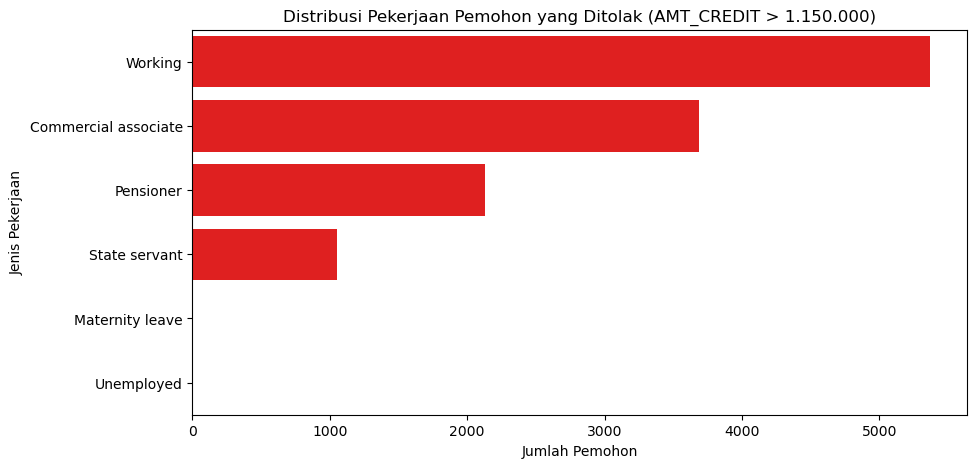

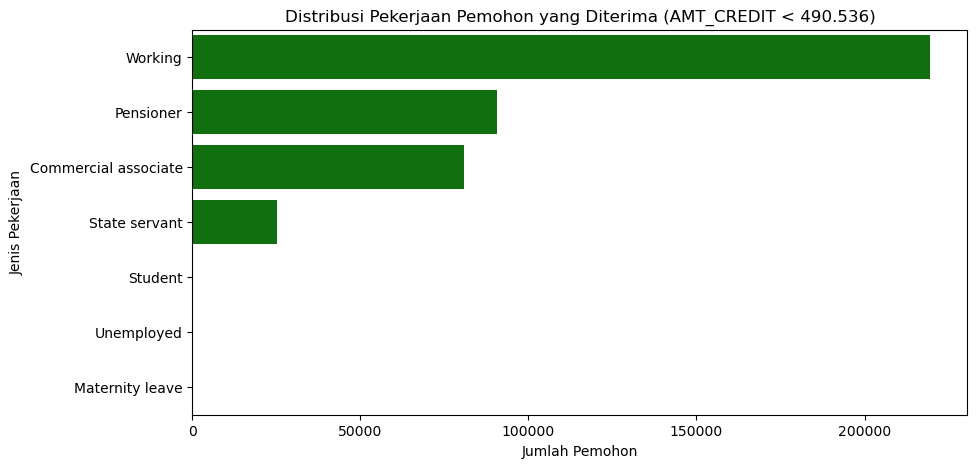

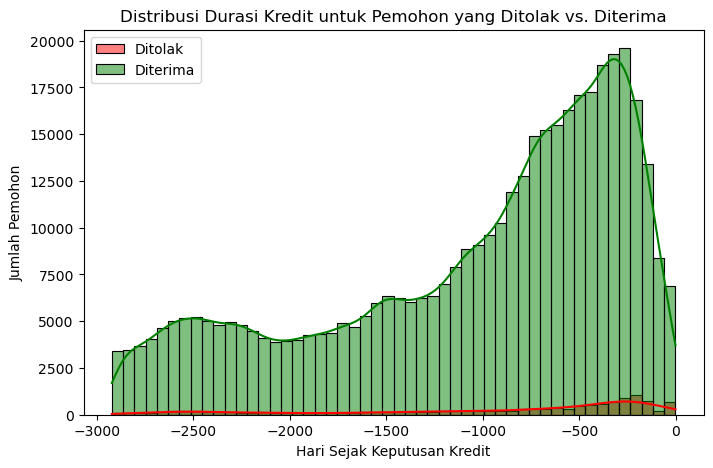

In [47]:
# Filter data berdasarkan threshold
high_credit_refused = refused_clients_clean[refused_clients_clean["AMT_CREDIT_x"] > 1150000.0]
low_credit_approved = approved_clients_clean[approved_clients_clean["AMT_CREDIT_x"] < 490536.0]

# Cek perbedaan income
print("\nStatistik Income Pemohon yang Ditolak (AMT_CREDIT > 1.150.000):")
print(high_credit_refused["AMT_INCOME_TOTAL"].describe())

print("\nStatistik Income Pemohon yang Diterima (AMT_CREDIT < 490.536):")
print(low_credit_approved["AMT_INCOME_TOTAL"].describe())

# Cek distribusi pekerjaan pemohon yang ditolak dan diterima
plt.figure(figsize=(10, 5))
sns.countplot(y=high_credit_refused["NAME_INCOME_TYPE"], order=high_credit_refused["NAME_INCOME_TYPE"].value_counts().index, color="red")
plt.title("Distribusi Pekerjaan Pemohon yang Ditolak (AMT_CREDIT > 1.150.000)")
plt.xlabel("Jumlah Pemohon")
plt.ylabel("Jenis Pekerjaan")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(y=low_credit_approved["NAME_INCOME_TYPE"], order=low_credit_approved["NAME_INCOME_TYPE"].value_counts().index, color="green")
plt.title("Distribusi Pekerjaan Pemohon yang Diterima (AMT_CREDIT < 490.536)")
plt.xlabel("Jumlah Pemohon")
plt.ylabel("Jenis Pekerjaan")
plt.show()

# Analisis durasi pinjaman
plt.figure(figsize=(8, 5))
sns.histplot(high_credit_refused["DAYS_DECISION"], bins=50, kde=True, color="red", label="Ditolak")
sns.histplot(low_credit_approved["DAYS_DECISION"], bins=50, kde=True, color="green", label="Diterima")
plt.title("Distribusi Durasi Kredit untuk Pemohon yang Ditolak vs. Diterima")
plt.xlabel("Hari Sejak Keputusan Kredit")
plt.ylabel("Jumlah Pemohon")
plt.legend()
plt.show()


In [48]:
reject_reason_counts = merged_data["CODE_REJECT_REASON"].value_counts()

print(reject_reason_counts)

CODE_REJECT_REASON
XAP       1145533
HC         145984
LIMIT       47773
SCO         32636
CLIENT      22771
0           16454
SCOFR       10875
XNA          4378
VERIF        3079
SYSTEM        672
Name: count, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_20380\1672397518.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reject_reason_counts.index, y=reject_reason_counts.values, palette="coolwarm")


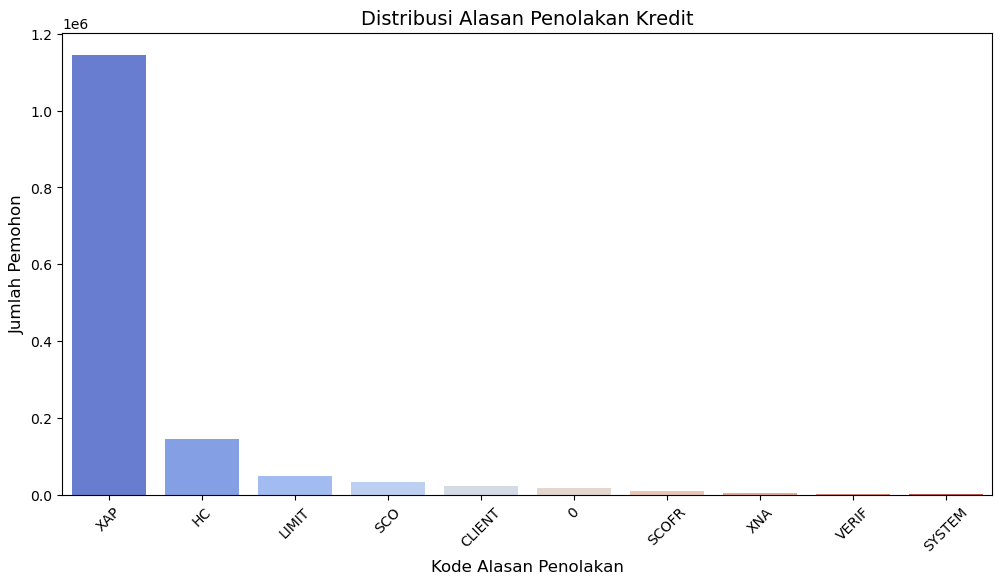

In [49]:
plt.figure(figsize=(12, 6))
sns.barplot(x=reject_reason_counts.index, y=reject_reason_counts.values, palette="coolwarm")

plt.title("Distribusi Alasan Penolakan Kredit", fontsize=14)
plt.xlabel("Kode Alasan Penolakan", fontsize=12)
plt.ylabel("Jumlah Pemohon", fontsize=12)
plt.xticks(rotation=45)
plt.show()

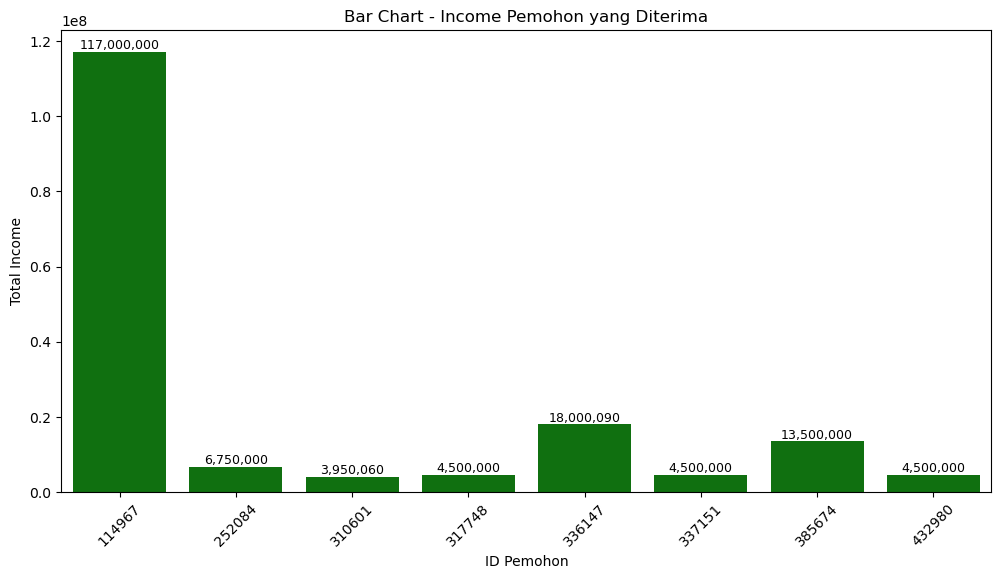

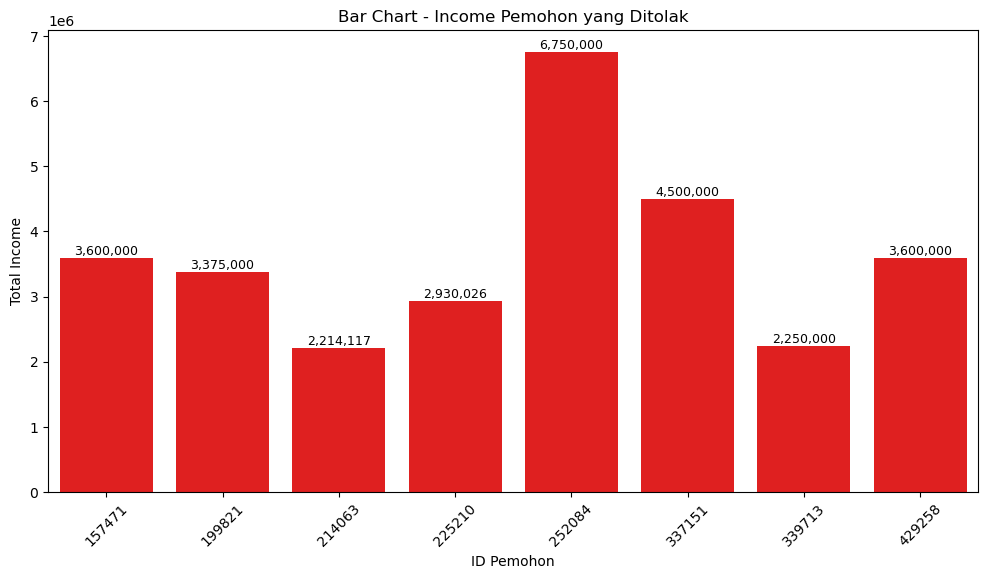

In [50]:
# Filter data berdasarkan status kontrak
income_approved_clean = merged_data[merged_data["NAME_CONTRACT_STATUS"] == "Approved"].copy()
income_refused_clean = merged_data[merged_data["NAME_CONTRACT_STATUS"] == "Refused"].copy()

# Urutkan berdasarkan AMT_INCOME_TOTAL (descending)
income_approved_sorted = income_approved_clean.sort_values(by="AMT_INCOME_TOTAL", ascending=False)
income_refused_sorted = income_refused_clean.sort_values(by="AMT_INCOME_TOTAL", ascending=False)

# Fungsi untuk membuat Bar Chart dengan value label di atas batang
def plot_bar_chart(data, title, color):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(y=data["AMT_INCOME_TOTAL"].head(20), x=data["SK_ID_CURR"].head(20), color=color)

    # Menambahkan nilai di atas setiap batang
    for p in ax.patches:
        ax.annotate(f"{p.get_height():,.0f}",  
                    (p.get_x() + p.get_width() / 2., p.get_height()),  
                    ha="center", va="bottom", fontsize=9, color="black", rotation=0)
    
    plt.ylabel("Total Income")
    plt.xlabel("ID Pemohon")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Bar Chart untuk Pemohon yang Diterima
plot_bar_chart(income_approved_sorted, "Bar Chart - Income Pemohon yang Diterima", "green")

# Bar Chart untuk Pemohon yang Ditolak
plot_bar_chart(income_refused_sorted, "Bar Chart - Income Pemohon yang Ditolak", "red")

112500.0
211500.0


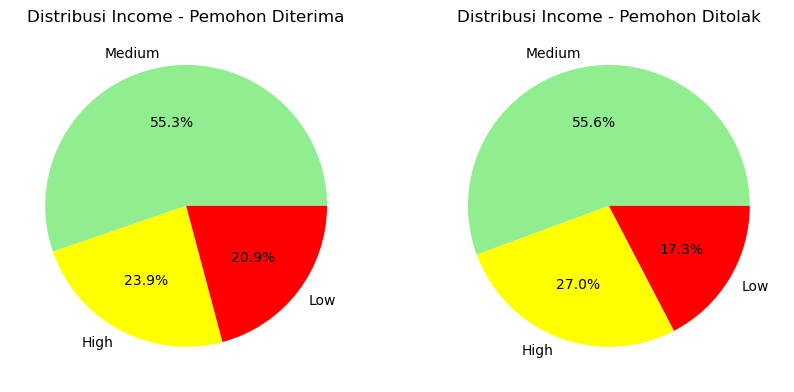

In [51]:
# Menghitung kuantil (Q1 & Q3) untuk menentukan kategori income
q1 = merged_data["AMT_INCOME_TOTAL"].quantile(0.25)
q3 = merged_data["AMT_INCOME_TOTAL"].quantile(0.75)

# Fungsi untuk mengkategorikan income
def categorize_income(income):
    if income < q1:
        return "Low"
    elif income < q3:
        return "Medium"
    else:
        return "High"

# Menambahkan kategori income ke dataset
merged_data["Income_Category"] = merged_data["AMT_INCOME_TOTAL"].apply(categorize_income)

# Memisahkan data berdasarkan status kontrak
approved_income = merged_data[merged_data["NAME_CONTRACT_STATUS"] == "Approved"]
refused_income = merged_data[merged_data["NAME_CONTRACT_STATUS"] == "Refused"]

# Menghitung distribusi kategori income
approved_counts = approved_income["Income_Category"].value_counts()
refused_counts = refused_income["Income_Category"].value_counts()
print(q1)
print(q3)
# Pie Chart untuk Pemohon yang Diterima
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(approved_counts, labels=approved_counts.index, autopct='%1.1f%%', colors=["lightgreen", "yellow", "red"])
plt.title("Distribusi Income - Pemohon Diterima")

# Pie Chart untuk Pemohon yang Ditolak
plt.subplot(1, 2, 2)
plt.pie(refused_counts, labels=refused_counts.index, autopct='%1.1f%%', colors=["lightgreen", "yellow", "red"])
plt.title("Distribusi Income - Pemohon Ditolak")

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_20380\3005348394.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=approved_income["Income_Category"], y=approved_income["ANNUITY_INCOME_RATIO"], palette=["lightgreen", "yellow", "red"])


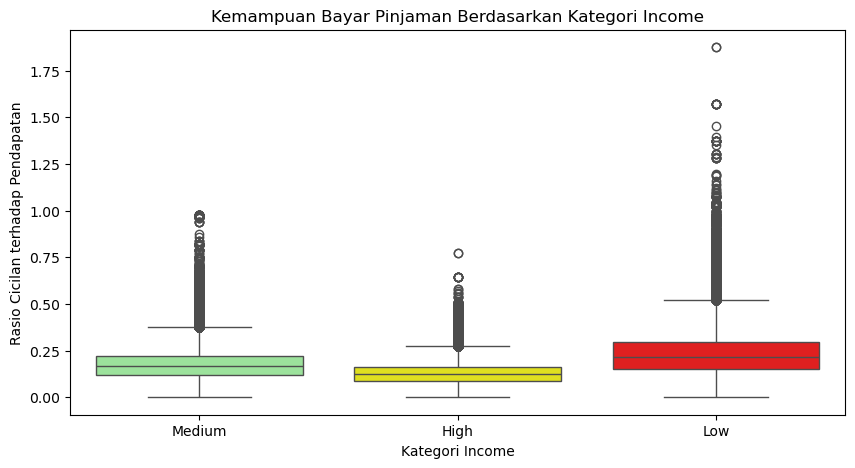

In [52]:
# Filter hanya pemohon yang diterima
approved_income = merged_data[merged_data["NAME_CONTRACT_STATUS"] == "Approved"].copy()

# Menghitung persentase cicilan tahunan terhadap income total
approved_income["ANNUITY_INCOME_RATIO"] = approved_income["AMT_ANNUITY_x"] / approved_income["AMT_INCOME_TOTAL"]

# Boxplot untuk melihat distribusi rasio cicilan terhadap pendapatan berdasarkan kategori income
plt.figure(figsize=(10, 5))
sns.boxplot(x=approved_income["Income_Category"], y=approved_income["ANNUITY_INCOME_RATIO"], palette=["lightgreen", "yellow", "red"])
plt.xlabel("Kategori Income")
plt.ylabel("Rasio Cicilan terhadap Pendapatan")
plt.title("Kemampuan Bayar Pinjaman Berdasarkan Kategori Income")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_20380\1476001827.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=merged_data["TARGET"], palette=["green", "red"])


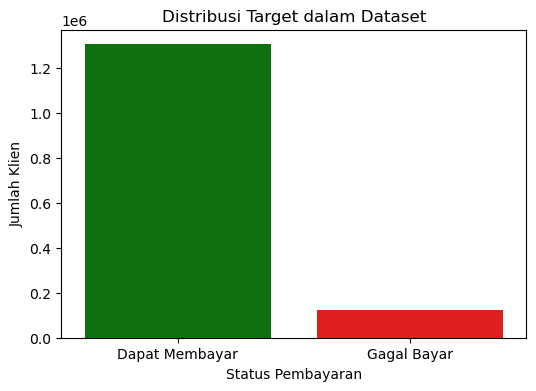

                   Count  Percentage
TARGET_CATEGORY                     
Dapat Bayar      1306815    91.37576
Gagal Bayar       123340     8.62424


In [126]:
# Distribusi Target (0 = Membayar, 1 = Gagal Bayar)
plt.figure(figsize=(6, 4))
sns.countplot(x=merged_data["TARGET"], palette=["green", "red"])
plt.xticks(ticks=[0, 1], labels=["Dapat Membayar", "Gagal Bayar"])
plt.title("Distribusi Target dalam Dataset")
plt.xlabel("Status Pembayaran")
plt.ylabel("Jumlah Klien")
plt.show()
merged_data['TARGET_CATEGORY'] = merged_data['TARGET'].apply(lambda x: 'Dapat Bayar' if x == 0 else 'Gagal Bayar')

# Menghitung jumlah kategori
target_count = merged_data['TARGET_CATEGORY'].value_counts()

# Menghitung persentase
target_percentage = merged_data['TARGET_CATEGORY'].value_counts(normalize=True) * 100

# Menampilkan hasil dalam jumlah dan persentase
result = pd.DataFrame({
    'Count': target_count,
    'Percentage': target_percentage
})

print(result)

In [54]:
#Statistik Deskriptif
print("\nStatistik Deskriptif Data:")
print(merged_data.describe())


Statistik Deskriptif Data:
         SK_ID_CURR        TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  1.430155e+06  1.430155e+06  1.430155e+06      1.430155e+06   
mean   2.784702e+05  8.624240e-02  4.038870e-01      1.736036e+05   
std    1.028021e+05  2.807218e-01  7.165176e-01      1.983303e+05   
min    1.000020e+05  0.000000e+00  0.000000e+00      2.565000e+04   
25%    1.893610e+05  0.000000e+00  0.000000e+00      1.125000e+05   
50%    2.789560e+05  0.000000e+00  0.000000e+00      1.575000e+05   
75%    3.675090e+05  0.000000e+00  1.000000e+00      2.115000e+05   
max    4.562550e+05  1.000000e+00  1.900000e+01      1.170000e+08   

       AMT_CREDIT_x  AMT_ANNUITY_x  AMT_GOODS_PRICE_x  \
count  1.430155e+06   1.430155e+06       1.430155e+06   
mean   5.893386e+05   2.704027e+04       5.289922e+05   
std    3.874204e+05   1.404126e+04       3.559720e+05   
min    4.500000e+04   0.000000e+00       0.000000e+00   
25%    2.700000e+05   1.679850e+04       2.385000e+05   
50%    5

In [55]:
# Select relevant features
features = ["HAS_PREV_LOAN", "TOTAL_PREV_LOANS", "COUNT_APPROVED", "COUNT_REFUSED", "CREDIT_TO_INCOME_RATIO", "ANNUITY_TO_INCOME_RATIO"]
X = merged_data[features]
y = merged_data["TARGET"]

In [56]:
X["SK_ID_CURR"] = merged_data["SK_ID_CURR"]

C:\Users\User\AppData\Local\Temp\ipykernel_20380\503355120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["SK_ID_CURR"] = merged_data["SK_ID_CURR"]


In [57]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [58]:
# Standardize data
X_test_ids = X_test["SK_ID_CURR"].values
X_train = X_train.drop(columns=["SK_ID_CURR"])
X_test = X_test.drop(columns=["SK_ID_CURR"])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
# Train model
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

C:\Users\User\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [60]:
# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [61]:
# Evaluation
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)
print(classification_report(y_test, y_pred))

ROC AUC Score: 0.7293082008367752
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    261296
           1       0.99      0.07      0.12     24735

    accuracy                           0.92    286031
   macro avg       0.96      0.53      0.54    286031
weighted avg       0.93      0.92      0.89    286031



In [62]:
# # Filter clients who can repay the loan
# X_test_df = pd.DataFrame(X_test, columns=features)
# X_test_df["Predicted"] = y_pred
# X_test_df["Actual"] = y_test.values
# can_repay = X_test_df[X_test_df["Predicted"] == 0]  # Clients predicted as no default
# print("\nClients predicted to repay the loan:")
# print(can_repay.head())

In [63]:
# Filter clients who can repay the loan
X_test_df = pd.DataFrame(X_test, columns=features)
X_test_df["SK_ID_CURR"] = X_test_ids  # Kembalikan ID klien ke dataframe
X_test_df["Predicted"] = y_pred
X_test_df["Actual"] = y_test.values

can_repay = X_test_df[X_test_df["Predicted"] == 0]

print("\nClients predicted to repay the loan (with SK_ID_CURR):")
print(can_repay[["SK_ID_CURR", "Predicted", "Actual"]])


Clients predicted to repay the loan (with SK_ID_CURR):
        SK_ID_CURR  Predicted  Actual
0           140918          0       0
1           445576          0       0
2           285541          0       0
3           133282          0       0
4           438945          0       1
...            ...        ...     ...
286026      144802          0       0
286027      154187          0       0
286028      291528          0       0
286029      405462          0       0
286030      347950          0       0

[284394 rows x 3 columns]


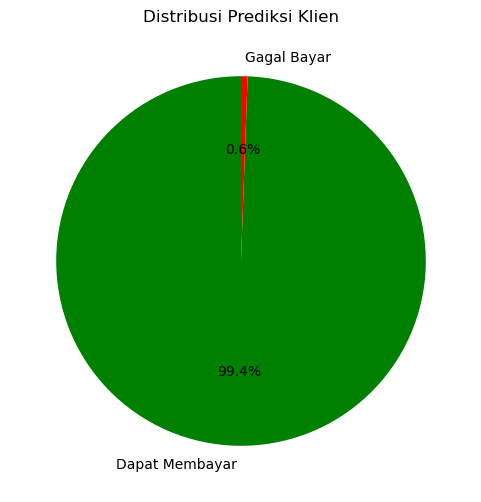

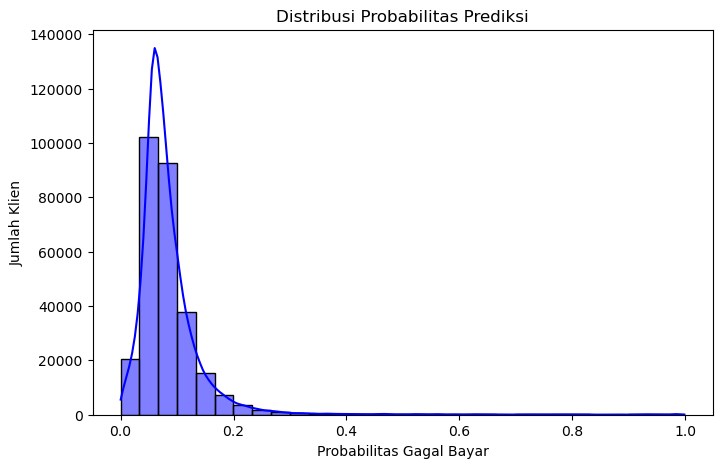

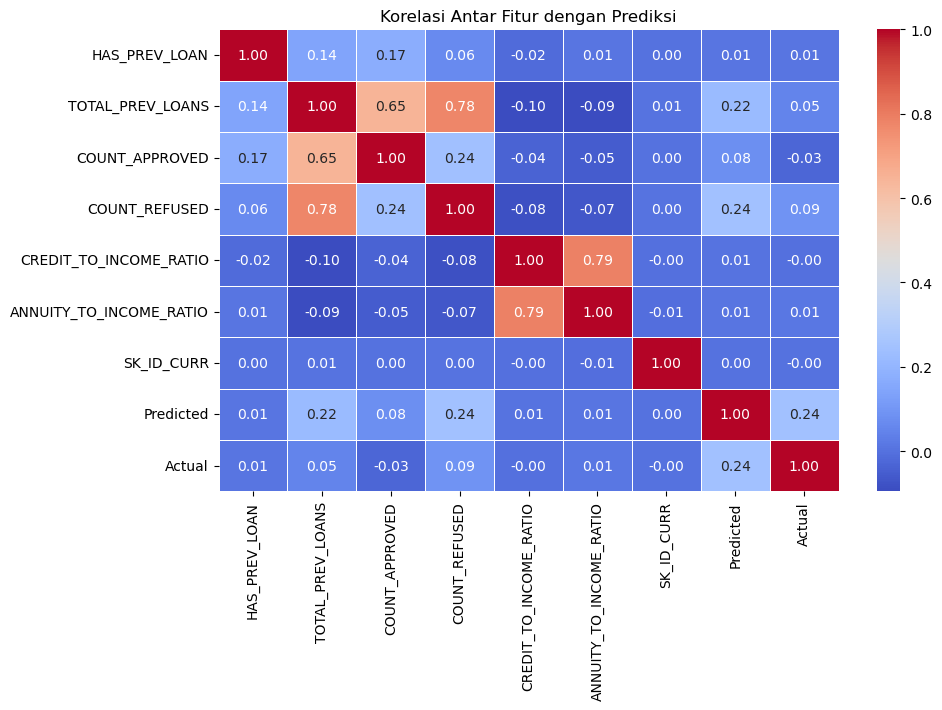

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pie Chart untuk distribusi hasil prediksi
plt.figure(figsize=(6, 6))
plt.pie(X_test_df["Predicted"].value_counts(), labels=["Dapat Membayar", "Gagal Bayar"],
        autopct="%1.1f%%", colors=["green", "red"], startangle=90)
plt.title("Distribusi Prediksi Klien")
plt.show()

# Distribusi probabilitas hasil prediksi
plt.figure(figsize=(8, 5))
sns.histplot(y_prob, bins=30, kde=True, color="blue")
plt.xlabel("Probabilitas Gagal Bayar")
plt.ylabel("Jumlah Klien")
plt.title("Distribusi Probabilitas Prediksi")
plt.show()

# Korelasi antara fitur dengan hasil prediksi
plt.figure(figsize=(10, 6))
sns.heatmap(X_test_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelasi Antar Fitur dengan Prediksi")
plt.show()


In [65]:
# Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [66]:
# Prediksi dengan Random Forest
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

In [67]:
# Evaluasi Random Forest
auc_rf = roc_auc_score(y_test, y_prob_rf)
print("ROC AUC Score (Random Forest):", auc_rf)
print(classification_report(y_test, y_pred_rf))

ROC AUC Score (Random Forest): 0.9879128735665348
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    261296
           1       0.96      0.89      0.92     24735

    accuracy                           0.99    286031
   macro avg       0.97      0.94      0.96    286031
weighted avg       0.99      0.99      0.99    286031



In [68]:
# Membuat DataFrame hasil prediksi untuk Random Forest
X_test_rf_df = pd.DataFrame(X_test, columns=features)
X_test_rf_df["SK_ID_CURR"] = X_test_ids  # Menambahkan ID klien ke dataframe
X_test_rf_df["Predicted_RF"] = y_pred_rf  # Prediksi dari Random Forest
X_test_rf_df["Actual"] = y_test.values  # Nilai aktual dari dataset


In [69]:
# Filter klien yang diprediksi dapat membayar pinjaman
can_repay_rf = X_test_rf_df[X_test_rf_df["Predicted_RF"] == 0]

In [70]:
# Menampilkan daftar klien yang diprediksi dapat membayar
print("\nClients predicted to repay the loan (Random Forest):")
print(can_repay_rf[["SK_ID_CURR", "Predicted_RF", "Actual"]])


Clients predicted to repay the loan (Random Forest):
        SK_ID_CURR  Predicted_RF  Actual
0           140918             0       0
1           445576             0       0
2           285541             0       0
3           133282             0       0
5           144650             0       0
...            ...           ...     ...
286026      144802             0       0
286027      154187             0       0
286028      291528             0       0
286029      405462             0       0
286030      347950             0       0

[263021 rows x 3 columns]


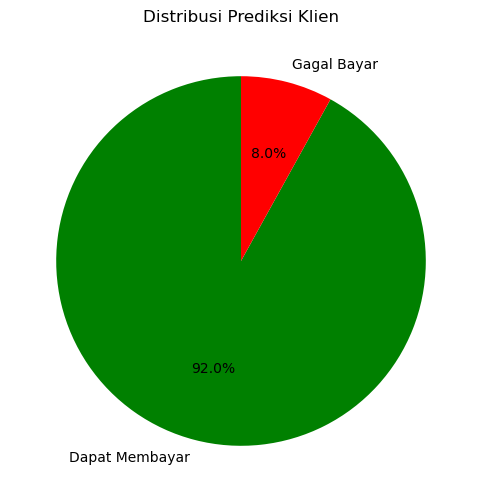

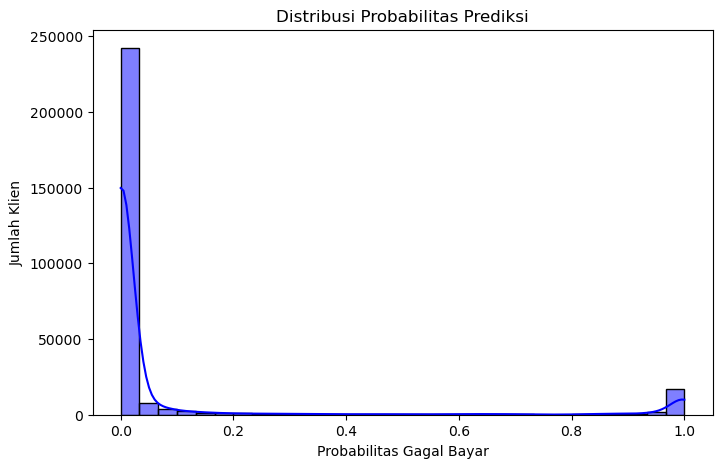

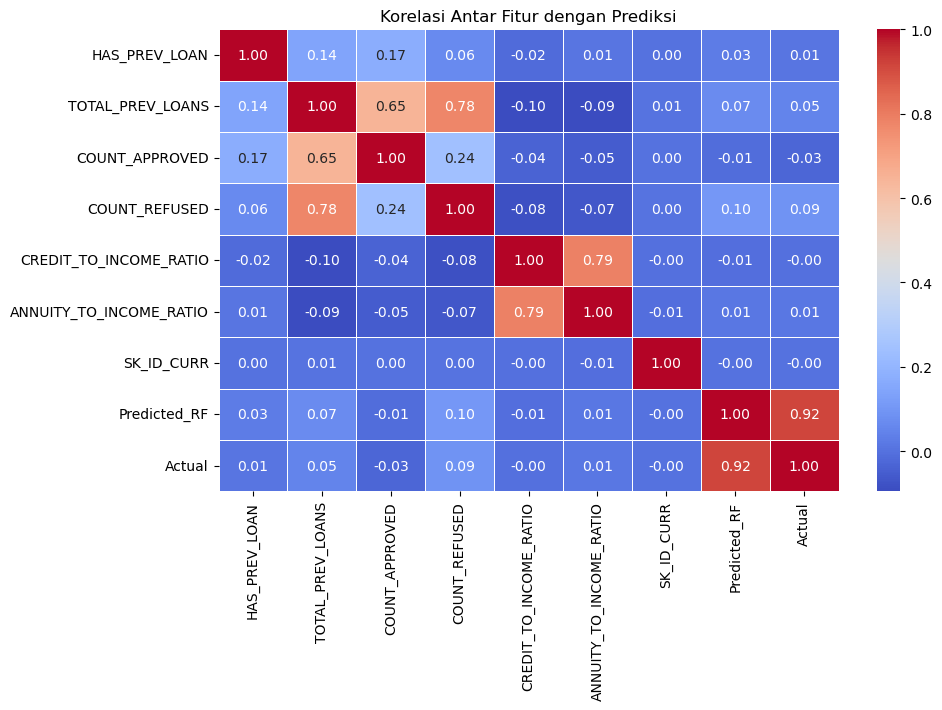

In [71]:

# Pie Chart untuk distribusi hasil prediksi
plt.figure(figsize=(6, 6))
plt.pie(X_test_rf_df["Predicted_RF"].value_counts(), labels=["Dapat Membayar", "Gagal Bayar"],
        autopct="%1.1f%%", colors=["green", "red"], startangle=90)
plt.title("Distribusi Prediksi Klien")
plt.show()

# Distribusi probabilitas hasil prediksi
plt.figure(figsize=(8, 5))
sns.histplot(y_prob_rf, bins=30, kde=True, color="blue")
plt.xlabel("Probabilitas Gagal Bayar")
plt.ylabel("Jumlah Klien")
plt.title("Distribusi Probabilitas Prediksi")
plt.show()

# Korelasi antara fitur dengan hasil prediksi
plt.figure(figsize=(10, 6))
sns.heatmap(X_test_rf_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelasi Antar Fitur dengan Prediksi")
plt.show()

In [72]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [73]:
# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

In [74]:
# Evaluation
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)
print(classification_report(y_test, y_pred))

ROC AUC Score: 0.6029289129582837
              precision    recall  f1-score   support

           0       0.91      1.00      0.95    261296
           1       0.43      0.00      0.00     24735

    accuracy                           0.91    286031
   macro avg       0.67      0.50      0.48    286031
weighted avg       0.87      0.91      0.87    286031



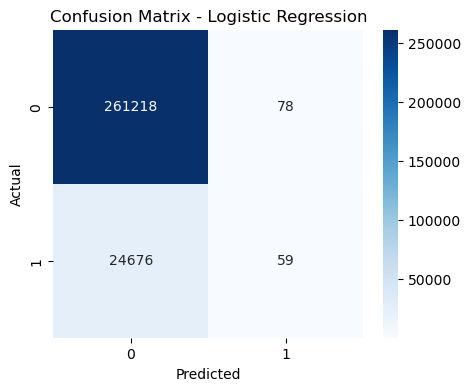

In [75]:
# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()



In [148]:
# Filter clients who can repay the loan
X_test_df = pd.DataFrame(X_test, columns=features)
X_test_df["SK_ID_CURR"] = X_test_ids  # Attach client ID
X_test_df["Predicted_LogReg"] = y_pred
X_test_df["Actual"] = y_test.values

can_repay = X_test_df[X_test_df["Predicted_LogReg"] == 0]  # Clients predicted as no default
print("\nClients predicted to repay the loan (with SK_ID_CURR):")
print(can_repay[["SK_ID_CURR", "Predicted_LogReg", "Actual"]])


Clients predicted to repay the loan (with SK_ID_CURR):
        SK_ID_CURR  Predicted_LogReg  Actual
0           140918                 0       0
1           445576                 0       0
2           285541                 0       0
3           133282                 0       0
4           438945                 0       1
...            ...               ...     ...
286026      144802                 0       0
286027      154187                 0       0
286028      291528                 0       0
286029      405462                 0       0
286030      347950                 0       0

[285894 rows x 3 columns]


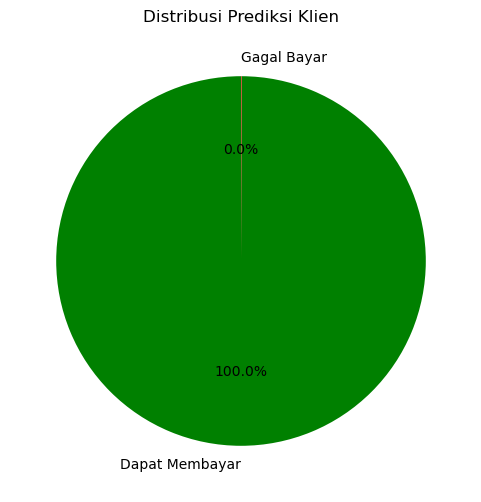

In [150]:
plt.figure(figsize=(6, 6))
plt.pie(X_test_df["Predicted_LogReg"].value_counts(), labels=["Dapat Membayar", "Gagal Bayar"],
        autopct="%1.1f%%", colors=["green", "red"], startangle=90)
plt.title("Distribusi Prediksi Klien")
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_20380\1290484638.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eda_data["COUNT_REFUSED"].fillna(0, inplace=True)


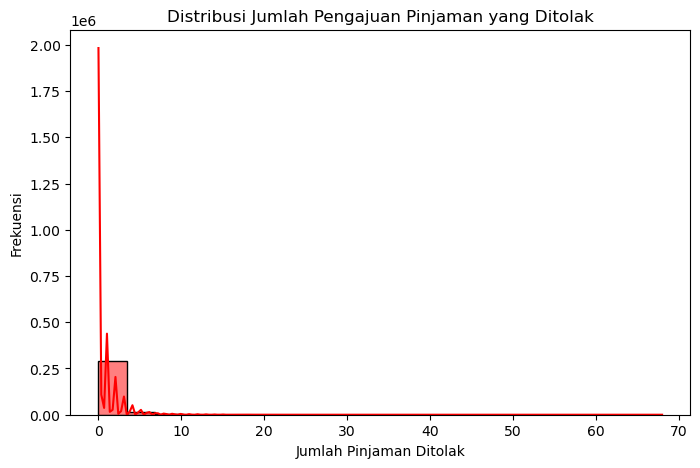

C:\Users\User\AppData\Local\Temp\ipykernel_20380\1290484638.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=eda_data["TARGET"], y=eda_data["COUNT_REFUSED"], palette="coolwarm")


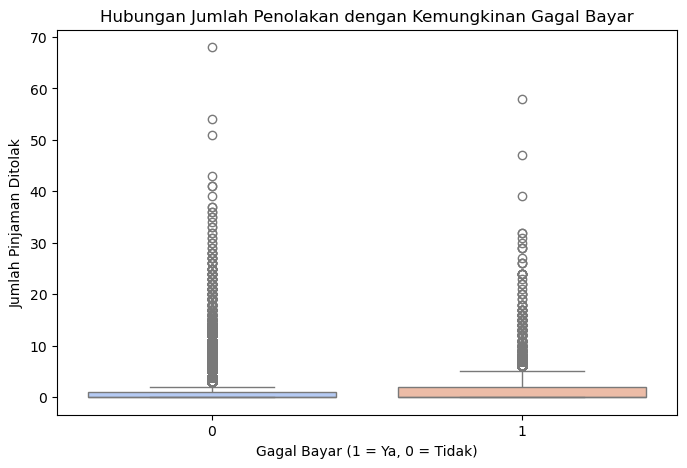

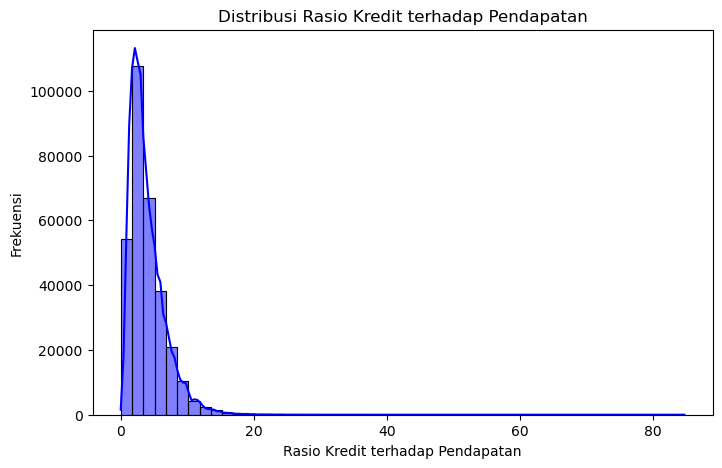

C:\Users\User\AppData\Local\Temp\ipykernel_20380\1290484638.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eda_data["HIGH_CREDIT_RATIO"], y=eda_data["TARGET"], palette="viridis")


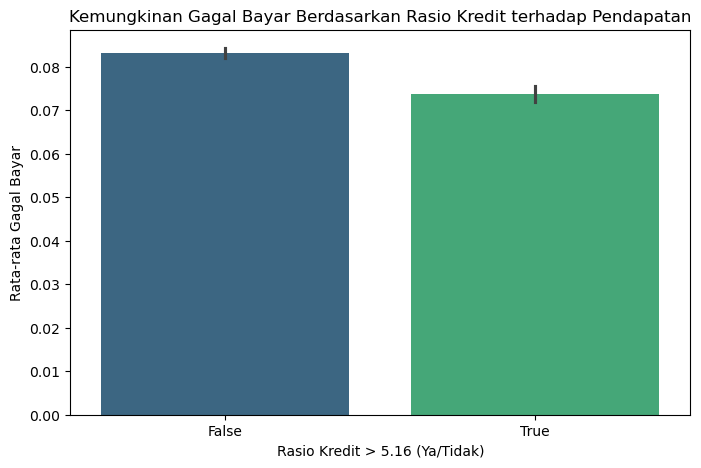

In [118]:
# Menghitung jumlah pinjaman yang ditolak per pelanggan
previous_application["COUNT_REFUSED"] = previous_application["NAME_CONTRACT_STATUS"].apply(lambda x: 1 if x == "Refused" else 0)
rejected_count = previous_application.groupby("SK_ID_CURR")["COUNT_REFUSED"].sum().reset_index()

# Menggabungkan dengan dataset utama
eda_data = application_train.merge(rejected_count, on="SK_ID_CURR", how="left")
eda_data["COUNT_REFUSED"].fillna(0, inplace=True)

# Visualisasi distribusi jumlah penolakan
plt.figure(figsize=(8, 5))
sns.histplot(eda_data["COUNT_REFUSED"], bins=20, kde=True, color="red")
plt.title("Distribusi Jumlah Pengajuan Pinjaman yang Ditolak")
plt.xlabel("Jumlah Pinjaman Ditolak")
plt.ylabel("Frekuensi")
plt.show()

# Hubungan jumlah penolakan dengan tingkat gagal bayar
plt.figure(figsize=(8, 5))
sns.boxplot(x=eda_data["TARGET"], y=eda_data["COUNT_REFUSED"], palette="coolwarm")
plt.title("Hubungan Jumlah Penolakan dengan Kemungkinan Gagal Bayar")
plt.xlabel("Gagal Bayar (1 = Ya, 0 = Tidak)")
plt.ylabel("Jumlah Pinjaman Ditolak")
plt.show()

# Membuat kolom rasio kredit terhadap pendapatan
eda_data["CREDIT_TO_INCOME_RATIO"] = eda_data["AMT_CREDIT"] / eda_data["AMT_INCOME_TOTAL"]

# Distribusi Rasio Kredit terhadap Pendapatan
plt.figure(figsize=(8, 5))
sns.histplot(eda_data["CREDIT_TO_INCOME_RATIO"], bins=50, kde=True, color="blue")
plt.title("Distribusi Rasio Kredit terhadap Pendapatan")
plt.xlabel("Rasio Kredit terhadap Pendapatan")
plt.ylabel("Frekuensi")
plt.show()

# Menentukan threshold optimal untuk rasio kredit terhadap pendapatan
threshold = eda_data["CREDIT_TO_INCOME_RATIO"].quantile(0.75)  # Mengambil Q3 sebagai batas awal

# Perbandingan gagal bayar berdasarkan rasio kredit
eda_data["HIGH_CREDIT_RATIO"] = eda_data["CREDIT_TO_INCOME_RATIO"] > threshold

plt.figure(figsize=(8, 5))
sns.barplot(x=eda_data["HIGH_CREDIT_RATIO"], y=eda_data["TARGET"], palette="viridis")
plt.title("Kemungkinan Gagal Bayar Berdasarkan Rasio Kredit terhadap Pendapatan")
plt.xlabel(f"Rasio Kredit > {threshold:.2f} (Ya/Tidak)")
plt.ylabel("Rata-rata Gagal Bayar")
plt.show()